In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rs
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.features import geometry_mask
from shapely.geometry import Point
from datetime import datetime
from sklearn.utils import resample
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../src/')
from evaluation import validation as val
%load_ext autoreload
%autoreload 2

# Prepare Stratified Sample

Details  
- type: pixel-based analysis
- design: stratified sampling approach by class
- total study area (all pixels in the strata): 26 districts
- total samples: when choosing sample count, consider how many points will be dropped from buffer zone and lack of ARD (when creating validation data).

Code: `src/evaluation/validation.py`

In [19]:
final = '../../tmp/ghana/preds/mosaic/final_2024-10-29.tif'
outfile = f'../../data/validation/sampled_points.shp'
buffer = 1000
params_path = '../../params.yaml'

In [3]:
sampled_points = val.run_validation_workflow(final, 
                                             outfile,
                                             buffer,
                                             params_path)

Class distribution: {0: 267810570, 1: 1354277, 2: 151443764, 3: 86913627}
Class proportions: {0: 52.77, 1: 0.27, 2: 29.84, 3: 17.13}
Total count (pixels): 507522238
Creating buffer zone with ['v08', 'v14', 'v15', 'v19', 'v20', 'v21', 'v22', 'v23'] batches
Total_samples: 1067.0
Sampling 563 points for class 0 out of 264952720 available pixels.
Sampling 2 points for class 1 out of 1139546 available pixels.
Sampling 318 points for class 2 out of 148586138 available pixels.
Sampling 182 points for class 3 out of 85917262 available pixels.


# Identify non-consensus labels
In the consensus labeling approach, any labels that do not have agreement between parties go to 3rd party review. This step sets up the CEO survey for the 3rd party.  
Requires the final sample csv from both parties.

In [15]:
john = pd.read_csv('../../data/validation/ceo-plantations-validation-john-sample-data-2024-11-27.csv')
jess = pd.read_csv('../../data/validation/ceo-plantations-validation-jessica-sample-data-2024-11-27.csv')
count = 502
john = john.iloc[0:count]
jess = jess.iloc[0:count]

In [5]:
jess

,plotid,sampleid,sample_internal_id,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_pred,System
0,0,0,765151974,-2.071047,10.615168,jessica.ertel@wri.org,False,2024-11-07 19:40,99.7 secs,Mapbox Satellite,NaN,POINT(-2.071047378 10.61516803),0,No vegetation
1,1,1,765151975,-0.100567,6.578401,jessica.ertel@wri.org,False,2024-10-29 19:33,7.8 secs,Mapbox Satellite,NaN,POINT(-0.100566997 6.578400683),0,No vegetation
2,2,2,765151976,-0.827740,10.418476,jessica.ertel@wri.org,False,2024-10-29 19:33,23.9 secs,Mapbox Satellite,NaN,POINT(-0.827739714 10.4184762),0,Agroforestry
3,3,3,765151977,-0.488447,10.894204,jessica.ertel@wri.org,False,2024-10-29 19:34,47.2 secs,Mapbox Satellite,NaN,POINT(-0.488447451 10.89420435),0,No vegetation
4,4,4,765151978,-0.735697,10.335053,jessica.ertel@wri.org,False,2024-10-29 19:34,33.0 secs,Mapbox Satellite,NaN,POINT(-0.735697176 10.33505297),0,No vegetation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,497,497,765152471,-1.280893,10.549364,jessica.ertel@wri.org,False,2024-11-15 12:51,24.1 secs,Mapbox Satellite,NaN,POINT(-1.280893363 10.54936437),0,No vegetation
498,498,498,765152472,-0.607534,10.678095,jessica.ertel@wri.org,False,2024-11-15 12:52,59.9 secs,Mapbox Satellite,NaN,POINT(-0.60753436 10.67809504),0,Agroforestry
499,499,499,765152473,-2.638796,9.626495,jessica.ertel@wri.org,False,2024-11-15 12:52,20.6 secs,Mapbox Satellite,NaN,POINT(-2.63879582 9.626494894),0,No vegetation
500,500,500,765152474,-1.574256,10.753518,jessica.ertel@wri.org,False,2024-11-15 12:52,20.8 secs,Mapbox Satellite,NaN,POINT(-1.574256032 10.75351755),0,No vegetation


In [48]:
def confirm_ready(df):
    df = df.rename(columns={"System": "system"})
    missing_values = df[df['system'].isna()]
    if len(missing_values) > 0:
        print(f"WARNING: There are {len(missing_values)} samples with no label. Review the CEO survey.")
        return None
    df = df[['plotid', 'system', 'lon', 'lat',]]    
    return df

def determine_label(row):
    '''
    If system_jess == system_john, the function immediately returns the matching value.
    If system_jess is 'unknown', return system_john.
    If system_john is 'unknown', return system_jess.
    If neither of the above conditions is met, return 'nc'.
    '''
    if row['system_jess'] == row['system_john']:
        return row['system_jess']
    
    return row['system_john'] if row['system_jess'] == 'Unknown' else (
           row['system_jess'] if row['system_john'] == 'Unknown' else 'nc')
    
def non_consensus_survey(df1, df2):
    '''
    df1 must be jess
    df2 must be john
    Creates a csv with non-consensus plots for 3rd party labeling
    Creates a clean csv with consensus plots for validation
    '''
    df1 = confirm_ready(df1)
    df2 = confirm_ready(df2)
    
    consensus = df1.merge(df2[['plotid', 'system']], 
                      on='plotid', 
                      suffixes=('_jess', '_john'))
    
    # create final label column
    consensus['final_label'] = consensus.apply(determine_label, axis=1)
    
    non_consensus = consensus[consensus.final_label == 'nc']
    print("Total non-consensus rows:", len(non_consensus))
    non_consensus = non_consensus[['plotid', 'lon', 'lat']]

    # drop all rows marked unknown or nc
    consensus = consensus[consensus.final_label != 'Unknown'].reset_index(drop=True)
    consensus = consensus[consensus.final_label != 'nc'].reset_index(drop=True)
    consensus = consensus[['plotid', 'lon', 'lat', 'final_label']]    

    non_consensus.to_csv('../../data/validation/non_consensus_labels.csv')
    consensus.to_csv('../../data/validation/consensus_labels.csv')
    return consensus, non_consensus

con, noncon = non_consensus_survey(jess, john, 'xyz')

Total non-consensus rows: 63


In [ ]:
## Quick check of labels

In [11]:
merge = john[['plotid', 'System']].merge(jess[['plotid', 'System']], on='plotid', suffixes=('_john', '_jess'))

non_matching = merge[merge['System_john'] != merge['System_jess']]
total_non_matching = non_matching.shape[0]
print("Total count of non-matching rows:", total_non_matching)

Total count of non-matching rows: 89


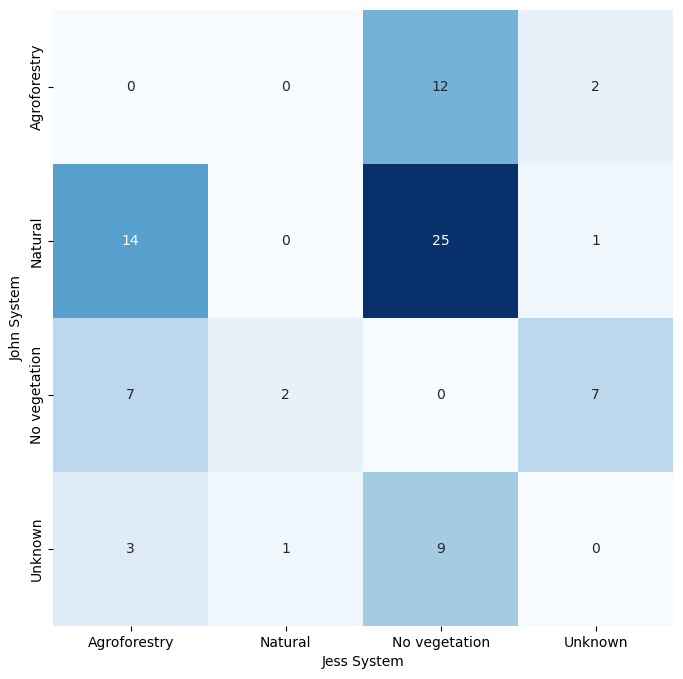

In [9]:
conf_matrix = pd.crosstab(non_matching['System_john'], non_matching['System_jess'], rownames=['John System'], colnames=['Jess System'])

plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()

# Additional validation points
To account for the samples labeled unknown, more validation points are required. Adds more monoculture samples as well as samples for all classes to account for dropped samples in round 1. This uses a manually assigned class proportion. These points should be cross referenced with the original batch to ensure no overlap. (or add something into the code to ensure this step happens).

In [17]:
js = pd.read_csv(f'../../data/validation/ceo-plantations-validation-jessica-sample-data-2024-11-27.csv')
js.System.value_counts()

No vegetation    417
Agroforestry     339
Natural          155
Unknown          147
Monoculture        4
Name: System, dtype: int64

In [18]:
js.shape

(1065, 14)

In [16]:
# which class do the unknowns primary fall into
unknown_samples = js[js.System == 'Unknown']['pl_pred']
unknown_samples.value_counts()

0    63
2    45
3    39
Name: pl_pred, dtype: int64

In [23]:
# looking at proportion of unknowns for each class, add
# {0: 40, 1: 50, 2: 50, 3: 60}
sampled_points = val.run_validation_workflow(final, 
                                             f'../../data/validation/sampled_points_v2.shp',
                                             buffer,
                                             params_path,
                                             valv1=f'../../data/validation/ceo-plantations-validation-jessica-plot-data-2024-11-27.csv',
                                             total_samples=200)

Class distribution: {0: 267810570, 1: 1354277, 2: 151443764, 3: 86913627}
Class proportions: {0: 52.77, 1: 0.27, 2: 29.84, 3: 17.13}
Total count (pixels): 507522238
Creating buffer zone with ['v08', 'v14', 'v15', 'v19', 'v20', 'v21', 'v22', 'v23'] batches
Total_samples: 200
Sampling 40 points for class 0 out of 246763275 available pixels.
Sampling 50 points for class 1 out of 1080596 available pixels.
Sampling 50 points for class 2 out of 138349526 available pixels.
Sampling 60 points for class 3 out of 79684828 available pixels.


# Evaluate Model

(prototyped)

In [10]:
## first testing this with jessica only
js = pd.read_csv(f'../../data/validation/ceo-plantations-validation-jessica.csv')
js2 = pd.read_csv(f'../../data/validation/ceo-plantations-validation2-jessica.csv')


In [4]:
js.head()

,plotid,sampleid,sample_internal_id,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_pred,System
0,0,0,765151974,-2.071047,10.615168,jessica.ertel@wri.org,False,2024-11-07 19:40,99.7 secs,Mapbox Satellite,NaN,POINT(-2.071047378 10.61516803),0,No vegetation
1,1,1,765151975,-0.100567,6.578401,jessica.ertel@wri.org,False,2024-10-29 19:33,7.8 secs,Mapbox Satellite,NaN,POINT(-0.100566997 6.578400683),0,No vegetation
2,2,2,765151976,-0.827740,10.418476,jessica.ertel@wri.org,False,2024-10-29 19:33,23.9 secs,Mapbox Satellite,NaN,POINT(-0.827739714 10.4184762),0,Agroforestry
3,3,3,765151977,-0.488447,10.894204,jessica.ertel@wri.org,False,2024-10-29 19:34,47.2 secs,Mapbox Satellite,NaN,POINT(-0.488447451 10.89420435),0,No vegetation
4,4,4,765151978,-0.735697,10.335053,jessica.ertel@wri.org,False,2024-10-29 19:34,33.0 secs,Mapbox Satellite,NaN,POINT(-0.735697176 10.33505297),0,No vegetation


In [ ]:
# Load the model
model_path = os.path.join(RESULTS_FOLDER, "model_SI_LULC.pkl")
model = joblib.load(model_path)

# load the test features
features_test = 

# Predict the test labels
predicted_labels_test = model.predict(features_test)


class_labels = np.unique(labels_test)
class_names = ['no tree', 'monoculture', 'agroforestry', 'natural']
mask = np.in1d(predicted_labels_test, labels_test)  # noqa: NPY201
predictions = predicted_labels_test[mask]
true_labels = labels_test[mask]

# Extract and display metrics
f1_scores = metrics.f1_score(true_labels, predictions, labels=class_labels, average=None)
avg_f1_score = metrics.f1_score(true_labels, predictions, average="weighted")
recall = metrics.recall_score(true_labels, predictions, labels=class_labels, average=None)
precision = metrics.precision_score(true_labels, predictions, labels=class_labels, average=None)
accuracy = metrics.accuracy_score(true_labels, predictions)

print("Classification accuracy {:.1f}%".format(100 * accuracy))
print("Classification F1-score {:.1f}%".format(100 * avg_f1_score))
print()
print("             Class              =  F1  | Recall | Precision")
print("         --------------------------------------------------")
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    line_data = (lulctype, f1_scores[idx] * 100, recall[idx] * 100, precision[idx] * 100)
    print("         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}".format(*line_data))

In [ ]:
## Confusion Matrix
# visual inspo: https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-map/SI_LULC_pipeline.ipynb

## Other Exercises

In [2]:
# create a comb mosaic
def mosaic_tif(tifs_to_mosaic, outpath):

    ''''
    Takes in a list of raster files and
    merges them to form a single tif.

    '''
    dir = f'../../tmp/ghana/preds/mosaic/'
    reader_mode = []

    for file in tifs_to_mosaic:
        src = rs.open(dir+file)
        reader_mode.append(src) 
    print(f'Merging {len(reader_mode)} tifs.')

    mosaic, out_transform = merge(reader_mode)
    date = datetime.today().strftime('%Y-%m-%d')
    outpath = f"{dir}{outpath}_{date}.tif"
    out_meta = src.meta.copy()  
    out_meta.update({'driver': "GTiff",
                     'dtype': 'uint8',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_transform,
                     'compress':'lzw',
                     'nodata': 255})

    with rs.open(outpath, "w", **out_meta) as dest:
        dest.write(mosaic)

    # Ensure to close all files
    for src in reader_mode:
        src.close()

    return None

In [3]:
tifs = ['pd_north_FINAL.tif',
        'pd_east_FINAL.tif',
        'pd_west_FINAL.tif',
       ]

mosaic_tif(tifs, 'final')

Merging 3 tifs.


In [ ]:
## legacy code

In [80]:
# confirm the AOI with 3 different methods
# land_use_map.size	
# Very fast, direct access to array size	
# Includes 255 and other invalid values in the count
# Getting the total number of pixels

# np.bincount()
# Efficiently counts only specified valid classes
# Limited by minlength, ignores other valid classes	
# If you know exactly which classes to count

# Conditional sum()	
# Counts all pixels except 255, flexible
# Slower and more memory-intensive for large datasets
# When you want to exclude 255 without specifying valid classes

counts = np.bincount(land_use_map.flatten(), minlength=4) 
classes = [0, 1, 2, 3] 
valid_counts = counts[classes]
total_count = valid_counts.sum()
lulc_count = sum(land_use_map[land_use_map != 255])

print(land_use_map.size)
print(total_count)
print(lulc_count)